## 使用 GAN 生成一个类似二次曲线

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# torch.manual_seed(1)       # reproducible
# np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001       # learning rate for generator
LR_D = 0.0001       # learning rate for discriminator
N_IDEAS = 5         # think of this as number of ideas for generating an art work(Generator)
ART_COMPONENTS = 15 # it could be total point G can drew in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

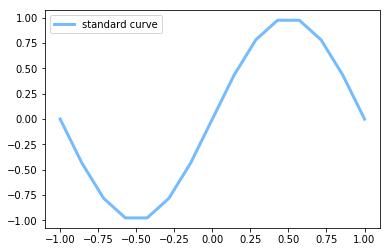

In [59]:
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], np.sin(PAINT_POINTS[0] * np.pi), c='#74BCFF', lw=3, label='standard curve')
plt.legend(loc='best')
plt.show()

In [60]:
def artist_works():    # painting from the famous artist (real target)
    #a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    r = 0.02 * np.random.randn(1, ART_COMPONENTS)
    paintings = np.sin(PAINT_POINTS * np.pi) + r
    paintings = torch.from_numpy(paintings).float()
    return paintings

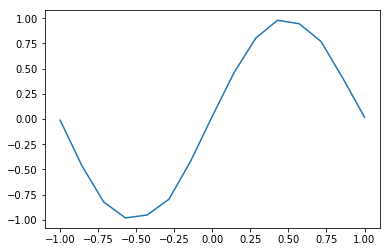

In [61]:
r = 0.02 * np.random.randn(1, ART_COMPONENTS)
paintings = np.sin(PAINT_POINTS * np.pi) + r
plt.plot(PAINT_POINTS[0],paintings[0])
plt.show()

In [65]:
G = nn.Sequential(                  # Generator
    nn.Linear(N_IDEAS, 128),        # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS), # making a painting from these random ideas
)

D = nn.Sequential(                  # Discriminator
    nn.Linear(ART_COMPONENTS, 128), # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                   # tell the probability that the art work is made by artist
)

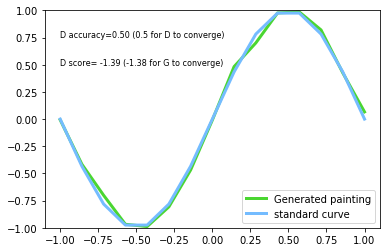

In [71]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

plt.ion()    # something about continuous plotting

D_loss_history = []
G_loss_history = []
for step in range(10000):
    artist_paintings = artist_works()          # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS) # random ideas
    G_paintings = G(G_ideas)                   # fake painting from G (random ideas)
    
    prob_artist0 = D(artist_paintings)         # D try to increase this prob
    prob_artist1 = D(G_paintings)              # D try to reduce this prob
    
    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    G_loss = torch.mean(torch.log(1. - prob_artist1))
    
    D_loss_history.append(D_loss)
    G_loss_history.append(G_loss)
    
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)    # reusing computational graph
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], np.sin(PAINT_POINTS[0] * np.pi), c='#74BCFF', lw=3, label='standard curve')
        plt.text(-1, 0.75, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 8})
        plt.text(-1, 0.5, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 8})
        plt.ylim((-1, 1));plt.legend(loc='lower right', fontsize=10);plt.draw();plt.pause(0.01)

plt.ioff()
plt.show()